In [249]:
#%%writefile cointegration_mult.py

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
import statistics
import seaborn as sns; sns.set(style="whitegrid")

def coefficients(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.params['temp'],
            "angular":model.params['x'],
            "intercept":model.params['const']}

def regression(y, x, period):
    y, x = get_values(y, x, period)
    pairs = pd.DataFrame()
    
    pairs['y'] = y
    pairs['x'] = x
    pairs['temp'] = timeline(period)
    
    X = pairs[['x', 'temp']]
    X = sm.add_constant(X)
    model = sm.OLS(pairs['y'], X).fit()
    return model

#O desvio padrão de uma estimativa é chamado de erro padrão
def stderr(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.bse['temp'],
            "angular":model.bse['x'],
            "intercept":model.bse['const']}
    
def residue(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    temp = timeline(period)
    res = y-coef['angular']*x-temp*coef['temp']-coef['intercept']
    #res[0]=0
    return res

def timeline(period):
    numbers = np.arange(1, period+1)
    temp = period - numbers + 1
    return temp

def getvolume(coef, y_volume, x_volume=0):
    return [y_volume, int(-y_volume*coef['angular'])]

def returns(y, x, period):
    y, x = get_values(y, x, period)
    y_log = np.log(y/y.shift(1))
    x_log = np.log(x/x.shift(1))
    return [y_log, x_log]
    
def get_values(y, x, period):
    if(period <= 0):
        return y, x
    
    y = y.iloc[:period]
    x = x.iloc[:period]
    return y, x

def correlation(y, x, period):
    y_log, x_log = returns(y, x, period)
    return y_log.corr(x_log)

def getdata(data, period):
    data_max = data[:period]
    return data_max

def invert(y, x, period):
    coef_main = coefficients(y, x, period)
    coef_invert = coefficients(x, y, period)
    if (abs(coef_main['temp'])<=abs(coef_invert['temp'])):
        return False
    return True

def ratio_diff(y, x, period):
    coef = coefficients(y, x, period)
    res = residue(y, x, period)
    diff = res.shift(1)-res
    diff[0]=0
    return diff

def ratio_continuo(y, x, period):
    y, x = get_values(y, x, period)
    return y-x
    
def intercept_coef(y, x, period):
    res = residue(y, x, period)
    diff = ratio_diff(y, x, period)

    target = pd.DataFrame(res, columns=["target"])
    target = sm.add_constant(target)
    model = sm.OLS(diff, target).fit()
    return model.params['target']

def intercept_inter(y, x, period):
    ratio_cont = ratio_continuo(y, x, period)
    ratio_cont[0]=0
    diff_r = ratio_diff(y, x, period)
    
    ratio_cont = sm.add_constant(ratio_cont)
    model = sm.OLS(diff_r, ratio_cont).fit()
    return model.params['const']

def ornstein_uhlenbeck(y, x, period):
    coef = intercept_coef(y, x, period)
    
    beta = -np.log(1+intercept_coef(y, x, period))
    alpha = -(coef/intercept_inter(y, x, period))
    
    std = residue(y, x, period).std()
    sigma=std*np.sqrt(np.log(1+coef)/(np.power((1+coef),2)-1))
    
    half = 2/beta
    return {
        "halffile": half,
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma
    }

def halflife_ser(y, x, period):
    return ornstein_uhlenbeck(y, x, period)['halffile']

def halflile(series):
    lag = np.roll(series, 1)
    lag[0] = 0
    ret = series - lag
    ret[0] = 0

    # adds intercept terms to X variable for regression
    lag2 = sm.add_constant(lag)
    res = sm.OLS(ret, lag2).fit()
    half_life = int(round(-np.log(2) / res.params[1],0))

    if half_life <= 0:
        half_life = 1
    return half_life
    
def statisticspair(y, x, desv_input, period):
    res = residue(y, x, period)
    std = res.std()
    return {
        "std": std,
        "std_up": desv_input*std,
        "std_down": -desv_input*std,
        "mean": res.mean(),
        "min": np.min(res)-2*std,
        "max": np.max(res)+2*std
    }


# acima do quadro "ESTATÍSTICAS"
def desv_stop(y, x, period):
    resid = residue(y, x, period)
    std_down = resid.mean()-3.1*resid.std()
    std_up = resid.mean()+3.1*resid.std()
    return {
        'up': std_up,
        'down':std_down
    }

def ratio_trade_stop(y, x, period):
    resid = residue(y, x, period)
    
    # acima do quadro "ESTATÍSTICAS"
    std_down = resid.mean()-3.1*resid.std()
    std_up = resid.mean()+3.1*resid.std()
    
    coef = coefficients(y, x, period)
    last_resid = resid[0]
    last_price = x[0]
    
    formula = (last_price*coef['angular']+coef['intercept']+last_resid+coef['temp']*period+min(last_resid-std_down,std_up-last_resid)*sinal(last_resid))
    return max(formula/last_price, last_price/formula)
    
def ratio_trade_output(y, x, period):
    price = x[0]
    coef = coefficients(y, x, period)
    formula = (coef['angular']*price+coef['intercept']+coef['temp']*period)/price
    return max(formula, 1/formula)

def ratio_trade_input(y, x, period):
    price = x[0]
    resid = residue(y, x, period)
    last_resid = resid[0]
    coef = coefficients(y, x, period)
    std_up = 2*resid.std()
    std_down = -2*resid.std()
    
    formula = (price*coef['angular']+coef['intercept']+last_resid+coef['temp']*period+min(last_resid-std_down,std_up-last_resid)*sinal(last_resid))
    return max(formula/price, price/formula)

def ratio_trade(y, x, period):
    ratio_input = ratio_trade_input(y, x, period)
    ratio_stop = ratio_trade_stop(y, x, period)
    ratio_output = ratio_trade_output(y, x, period)
    return {
        'input': ratio_input,
        'stop': ratio_stop,
        'output': ratio_output,
    }
    
def ratio_current(y, x):
    ratio = y[0]/x[0]
    return {
        "ratio": ratio,
        "value": 1/ratio
    }

def loss_percent(y, x, period):
    return -abs(ratio_trade_stop(y, x, period)/ratio_trade_input(y, x, period)-1)

def current_percent(y, x, period):
    ratio = ratio_current(y, x)
    return abs(ratio_trade_output(y, x, period)/max(ratio['ratio'], ratio['value'])-1)

def return_percent(y, x, period):
    return abs(ratio_trade_output(y, x, period)/ratio_trade_input(y, x, period)-1)

def loss(y, x, volume, period):
    return y[0]*abs(volume)*loss_percent(y, x, period)

def gain(y, x, volume, period):
    return current_percent(y, x, period)*abs(volume)*y[0]

def zscore(series):
    return (series - series.mean()) / np.std(series)

def sinal(value):
    if(value < 0):
        return -1
    return 1

def dickey_fuller(series):
    model = ts.adfuller(series, 1)
    p_value = model[1]
    statistic = model[0]

    # Dickey-Fuller
    is_stationary = False
    if (p_value < .05):
        is_stationary = True

    # Augmented Dickey Fuller (ADF)
    perc_stat = 0
    if (abs(statistic) > abs(model[4]['1%'])):
        perc_stat = 99
    elif (abs(statistic) > abs(model[4]['5%'])):
        perc_stat = 95
    elif (abs(statistic) > abs(model[4]['10%'])):
        perc_stat = 90
        
    return {
        "is_stationary": is_stationary,
        "p-value": p_value,
        "adf": perc_stat,
        "statistic": statistic
    }

#função DESVQ do excel
def desvq(values):
    return np.power(values-values.mean(), 2).sum()

#função EPADYX do excel
def epadyx(y, x, period):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    X = sm.add_constant(res)
    fit = sm.OLS(rdiff, X).fit()
    return np.sqrt(fit.mse_resid)
    
def adf_ser(y, x, period):
    res = residue(y, x, period)
    rdiff = ratio_diff(y, x, period)
    res[0]=0
    rdiff[0]=0

    inter_cof = intercept_coef(y, x, period)
    return inter_cof/(epadyx(rdiff, res, period)/np.sqrt(desvq(res)))

def rejeitado_h0(adf):
    if adf<=0:
        if adf<=-4.32: return 99
        if adf<=-3.67: return 95
        if adf<=-3.28: return 90
    else:
        if adf<=-3.58: return 99
        if adf<=-3.22: return 95
        if adf<=-2.6: return 90
    return 0

def dickey_fuller_ger(y, x, period):
    adf_statistic = adf_ser(y, x, period)
    rej = rejeitado_h0(adf_statistic)
    return {
        "statistic": adf_statistic,
        "adf": rej
    }

def predy(y, x, period):
    last_price = x[0]
    coef = coefficients(y, x, period)
    last_resid = residue(y, x, period)[0]
    pred = last_price*coef['angular']+coef['intercept']+last_resid+coef['temp']*period
    return pred

def signal(y, x, desv_input, period):
    y, x, get_values(y, x, period)
    resid = residue(y, x, period)[::-1]
    
    std = resid.std()
    resid_current = resid.iloc[-1]
    zscore_up = desv_input*std
    zscore_down = -desv_input*std
    zcurrent = 0
    descr = ''
    
    # >0; resíduo acima da linha 0
    if(resid_current > resid.mean()):
        descr = 'Short/Long'
        zcurrent = zscore_up
    else:
        descr = 'Long/Short'
        zcurrent = zscore_down
    
    oper_str = ''
    if (resid_current >= zscore_up):
        oper_str='Short'
    if (resid_current <= zscore_down):
        oper_str='Long'
        
    percent = (abs(resid_current)/abs(zcurrent))
    #1-descr
    #2-resíduo atual
    #3-percent distância da linha 0, quanto maior, melhor
    return {
        "descr": descr,
        "signal": oper_str,
        "is_signal": oper_str!='',
        "resid_current": resid_current,
        "percent_dist_mean": percent}

def list_periods():
    return [100, 120, 140, 160, 180, 200, 220, 240, 250]

def check_periods(y, x):
    rows=[]
    for period in list_periods():
        if (dickey_fuller(residue(y, x, period))['is_stationary']):
            rows.append(period)
    return rows

def analysis_by_periods(y, x):
    rows=[]
    for period in list_periods():
        # filter by period
        y_values, x_values = get_values(y, x, period)
        resid = residue(y_values, x_values, period)
        
        check = check_cointegration(y_values, x_values, period)
        half = halflile(resid)
        corr = correlation(y_values, x_values, period)
        
        rows.append([period, check['is_stationary'], check['p-value'], check['adf'], check['coef.ang'], half, corr])
        
    analysis = pd.DataFrame(rows, columns=['Period', 'Stationary', 'Dickey-Fuller', 'ADF', 'Beta', 'HalfLife', 'Corr'])
    return analysis

def check_cointegration(y, x, period):
    if (period == 0):
        period = len(y)
        
    dickey = dickey_fuller(residue(y, x, period))
    coeff = coefficients(y, x, period)
    
    return {"period": period,
            "is_stationary": dickey['is_stationary'],
            "p-value": dickey['p-value'],
            "adf": dickey['adf'],
            "coef.temp": coeff['temp'],
            "coef.ang": coeff['angular'],
            "coef.linear": coeff['intercept']
           }

def find(data):
    rows = []
    index=-1
    
    for y_symbol in data.columns:
        index = index + 1
        for x_symbol in data.columns[index+1:data.shape[1]]:#for x_symbol in data.columns:
            if (y_symbol == x_symbol):
                continue
                
            for period in [250, 240, 220, 200, 180, 160, 140, 120, 100]:
                check = check_cointegration(data[y_symbol], data[x_symbol], period)
                # find only an is stationary, then break looping
                if (check['is_stationary']):
                    rows.append([period, y_symbol, x_symbol, check['p-value'], check['adf'], check['coef.ang']])
                    break
    return rows

def find_pairs(data):
    df_pairs = pd.DataFrame(find(data), columns=['Period', 'Dependent', 'Independent', 'Dickey-Fuller', 'ADF', 'Beta'])
    return df_pairs

def apply_halflife(data, pairs):
    pairs['HalfLife'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        half = halflile(residue(y, x, period))
        pairs['HalfLife'].iloc[i]=half

def apply_corr(data, pairs):
    pairs['Corr'] = 0
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)

        corr = correlation(y, x, period)
        pairs['Corr'].iloc[i] = corr
        
def apply_signal(data, pairs, desv_input):
    pairs['Signal'] = 0
    pairs['SignalStr'] = ''
    
    for i, row in pairs.iterrows():
        period = row['Period']
        y, x = get_values(data[row['Dependent']], data[row['Independent']], period)
        
        sig = signal(y, x, desv_input, period)
        pairs['Signal'].iloc[i] = sig['percent_dist_mean']
        pairs['SignalStr'].iloc[i] = sig['descr']
        
def apply_periods(data, pairs):
    pairs['PeriodQt'] = 0
    pairs['PeriodStr'] = ''
    for i, row in pairs.iterrows():
        periods_ok = check_periods(data[row['Dependent']],  data[row['Independent']])

        descr = ''
        for per in periods_ok:
            if (descr!=''): descr=descr+','
            descr=descr+str(per)

        pairs['PeriodQt'].iloc[i] = len(periods_ok)
        pairs['PeriodStr'].iloc[i] = descr

def valuestr(message1=[], message2=[]):
    space = 40
    right = ''
    if (len(message1)>0):
        n = space-len(message1[1])
        right =  message1[0].ljust(n, ' ') + message1[1]
    
    lefht = ''
    if(len(message2) > 0):
        n = space-len(message2[1])
        lefht =  message2[0].ljust(n, ' ') + message2[1]
    
    print(right.ljust(n, ' ') + '   ' + lefht)
    
def summary(data, y_symbol, x_symbol, period, y_volume=100, x_volume=0, display_statistic=False):
    line = '==================================================================================='
    y, x = get_values(data[y_symbol], data[x_symbol], period)
    resid = residue(y, x, period)
    coef = coefficients(y, x, period)
    volume = getvolume(coef, y_volume, x_volume)
    sig = signal(y, x, 2, period)
    
    oper = 'Não'
    if (sig['signal']=='Short'):
        oper = 'Venda: {} / Compra:{}'.format(y_symbol, x_symbol)
    if (sig['signal']=='Long'):
        oper = 'Compra: {} / Venda:{}'.format(y_symbol, x_symbol)
    
    print(line)
    valuestr(['Período de Análise', str(period)], ['Entrada', oper])
    print(line)
    valuestr(['Independente', y_symbol], ['Dependente', x_symbol])
    valuestr(['R$', str(y[0])], ['R$', str(x[0])])
    valuestr(['Volume', str(volume[0])], ['Volume', str(volume[1])])
    
    y_finan = -y[0]*volume[0]
    x_finan = -x[0]*volume[1]
    print(line)
    valuestr(['Finan({}) R$'.format(y_symbol), str(y_finan)], ['Ratio', str(y[0]/x[0])])
    valuestr(['Finan({}) R$'.format(x_symbol), str(x_finan)], ['', ''])
    valuestr(['Margem  R$', str(abs(y_finan+x_finan))], ['', ''])
    
    print(line)
    valuestr(['Retorno  (%)', str(return_percent(y, x, period)*100)], ['Gain', str(gain(y, x, volume[0], period))])
    valuestr(['Atual    (%)', str(current_percent(y, x, period)*100)], ['Loss', str(loss(y, x, volume[0], period))])
    valuestr(['Loss     (%)', str(loss_percent(y, x, period)*100)], ['', ''])
    
    dickey = dickey_fuller(residue(y, x, period))
    print(line)
    valuestr(['Dickey Fuller', str(dickey['statistic'])], ['Meia Vida', str(halflile(resid))])    
    valuestr(['ADF', str(dickey['adf'])], ['Correlação  (%)', str(correlation(y, x, period)*100)])
    valuestr(['p-value', str(dickey['p-value'])], ['Inverter', str(invert(y, x, period))])
    valuestr(['', ''], ['Beta', str(coef['angular'])])
    
    print(line)
    valuestr(['Ratio Entrada', str(ratio_trade_input(y, x, period))])
    valuestr(['Ratio Saída', str(ratio_trade_output(y, x, period))])
    valuestr(['Ratio Stop', str(ratio_trade_stop(y, x, period))])
    
    print(line)
    listperiods = check_periods(data[y_symbol], data[x_symbol])
    print('Cointegrado em ({}): {}'.format(len(listperiods), listperiods))
    
    if (display_statistic):
        print(line)
        valuestr(['Coef.Temp', str(coef['temp'])], ['Coef', str(intercept_coef(y, x, period))])
        valuestr(['Coef.Ang', str(coef['angular'])], ['Intercept', str(intercept_inter(y, x, period))])
        valuestr(['Coef.Lin', str(coef['intercept'])], ['', ''])
        
    print(line)

def plot_residue2(y, x, period, desv_input=2, padronizar=True):
    plot_residue(residue(y, x, period), desv_input=desv_input, padronizar=padronizar)
    
def plot_residue(resid, desv_input=2, padronizar=True):
    resid = resid[::-1]
    if (padronizar):
        resid = zscore(resid)
    std = resid.std()
    resid.plot(figsize=(17, 6), linewidth=2)

    plt.xlabel('')
    plt.axhline(resid.mean())
    plt.axhline(0, color='black',label='mean') # Add the mean of residual
    plt.axhline(desv_input*std, color='red', linestyle='--', linewidth=2)
    plt.axhline(-desv_input*std, color='green', linestyle='--', linewidth=2)

In [250]:
summary(data, 'ENGI11', 'VVAR3', 140, y_volume=100)

Período de Análise                   140   Entrada                              Não
Independente                      ENGI11   Dependente                         VVAR3
R$                                 47.58   R$                                 15.86
Volume                               100   Volume                              -146
Finan(ENGI11) R$                 -4758.0   Ratio                                3.0
Finan(VVAR3) R$                  2315.56                                           
Margem  R$                       2442.44                                           
Retorno  (%)           8.805110522837168   Gain                  157.35282779466147
Atual    (%)          3.3071212230908253   Loss                  -230.4209372721282
Loss     (%)         -4.8428107875604915                                           
Dickey Fuller         -3.741519887340069   Meia Vida                              4
ADF                                   99   Correlação  (%)         65.725337

In [229]:
predy(y, x, period)

73.5

In [62]:
desv_stop(y, x, period)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


{'up': 9.195128008517367, 'down': -9.195128008517257}

In [65]:
ratio_trade(y, x, period)

{'input': 3.01704518712235,
 'stop': 3.1438046027346664,
 'output': 2.7865735223726866}

In [5]:
import importlib
%matplotlib inline
#%run Cointegration.py
import Cointegration as coint
importlib.reload(coint)

<module 'Cointegration' from 'D:\\trades\\pairs_trading_b3\\Cointegration.py'>

In [6]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]

In [ ]:
pairs = find_pairs(data)
apply_halflife(data, pairs)
apply_corr(data, pairs)
apply_signal(data, pairs, 2)
apply_periods(data, pairs)

In [16]:
pairs

,Period,Dependent,Independent,Dickey-Fuller,ADF,Beta,HalfLife,Corr,Signal,SignalStr,PeriodQt,PeriodStr
0,250,ABEV3,AZUL4,0.031658,95,0.117314,9,0.615632,1.172332,Short/Long,2,"100,250"
1,100,ABEV3,B3SA3,0.000085,99,0.228449,2,0.628667,0.108828,Long/Short,1,100
2,250,ABEV3,BBAS3,0.041324,95,0.222135,10,0.551361,0.885949,Short/Long,7,"100,160,180,200,220,240,250"
3,250,ABEV3,BBDC3,0.037843,95,0.341824,11,0.575381,0.946095,Short/Long,8,"100,120,140,160,180,200,220,250"
4,250,ABEV3,BBDC4,0.035837,95,0.350037,11,0.561564,0.830845,Short/Long,9,"100,120,140,160,180,200,220,240,250"
...,...,...,...,...,...,...,...,...,...,...,...,...
1892,250,USIM5,WEGE3,0.017591,95,0.280947,11,0.456577,0.318768,Long/Short,6,"160,180,200,220,240,250"
1893,100,VALE3,VIVT4,0.026121,95,1.221917,5,0.491082,0.116558,Long/Short,1,100
1894,250,VALE3,VVAR3,0.027792,95,1.157682,9,0.537557,0.426913,Short/Long,5,"100,200,220,240,250"
1895,180,VIVT4,VVAR3,0.048437,90,0.648441,7,0.430804,0.405852,Long/Short,5,"100,120,140,160,180"


In [18]:
pairs.to_csv('datasets/cointegrated_pairs_mult.csv', index=False)
print('Saved successfully!!!')

Saved successfully!!!


# Other

In [91]:
#ABEV3 AZUL4
y_symbol = 'CSAN3'
x_symbol = 'FLRY3'
period = 250

In [92]:
y, x = get_values(data[y_symbol], data[x_symbol], 0)

In [93]:
print('{}:  {} {}:  {}'.format(y_symbol, y[0], x_symbol, x[0]))
print('halflile: {}'.format(halflile(residue(y, x, period))))
print('halflife_ser: {}'.format(halflife_ser(y, x, period)))
print('correlation: {}'.format(correlation(y, x, period)))
print('ratio_trade_stop: {}'.format(ratio_trade_stop(y, x, period)))
print('ratio_trade_output: {}'.format(ratio_trade_output(y, x, period)))
print('ratio_trade_input: {}'.format(ratio_trade_input(y, x, period)))
print('loss_percent: {}'.format(loss_percent(y, x, period)*100))
print('current_percent: {}'.format(current_percent(y, x, period)*100))
print('return_percent: {}'.format(return_percent(y, x, period)*100))
print('loss: {}'.format(loss(y, x, 1000, period)))
print('gain: {}'.format(gain(y, x, 1000, period)))
print('intercept_coef: {}'.format(intercept_coef(y, x, period)))
print('intercept_inter: {}'.format(intercept_inter(y, x, period)))
print('invert: {}'.format(invert(y, x, period)))

CSAN3:  73.5 FLRY3:  25.74
halflile: 5
halflife_ser: 12.657391674226682
correlation: 0.6391875601817154
ratio_trade_stop: 3.1438046027346664
ratio_trade_output: 2.7865735223726866
ratio_trade_input: 3.01704518712235
loss_percent: -4.2014423964666925
current_percent: 2.4130578695606197
return_percent: 7.638986175393903
loss: -3088.060161403019
gain: 1773.5975341270555
intercept_coef: -0.14615913030833613
intercept_inter: 0.6429854892270765
invert: True


In [94]:
epadyx(y, x, period)

1.5359790914654732

In [95]:
np.sqrt(desvq(residue(y, x, period)))

46.8053782520288

In [96]:
check_cointegration(y, x, period)

{'period': 250,
 'is_stationary': True,
 'p-value': 0.0003939304681746343,
 'adf': 99,
 'coef.temp': 0.07747302462131306,
 'coef.ang': 2.3368757788503745,
 'coef.linear': -7.793036237063955}

In [97]:
dickey_fuller(residue(y, x, period))

{'is_stationary': True,
 'p-value': 0.0003939304681746343,
 'adf': 99,
 'statistic': -4.330027289051755}

In [98]:
dickey_fuller_ger(y, x, period)

{'statistic': -4.455007781289907, 'adf': 99}

In [99]:
statisticspair(y, x, 2, period)

{'std': 2.966170325328165,
 'std_up': 5.93234065065633,
 'std_down': -5.93234065065633,
 'mean': 5.4797055781818925e-14,
 'min': -16.137959381625446,
 'max': 13.446655225529899}

In [100]:
ornstein_uhlenbeck(y, x, period)

{'halffile': 12.657391674226682,
 'beta': 0.15801043781180077,
 'alpha': 0.22731326407386251,
 'sigma': 2.2651124788923895}

In [12]:
coefficients(y, x, period)

{'temp': 0.15756965168607628,
 'angular': 1.257713868250663,
 'intercept': -13.850534756052681}

In [13]:
reg = regression(y, x, period)

In [14]:
stderr(y, x, period)

{'temp': 0.0025803159344561957,
 'angular': 0.0225437786212992,
 'intercept': 1.2212294585292138}

In [15]:
signal(y, x, 2, period)

{'descr': 'Short/Long',
 'resid_current': 6.140895890533791,
 'percent_dist_mean': 1.289733040788447}

In [217]:
check_periods(data[y_symbol], data[x_symbol])

[120, 140, 160, 180, 200, 220, 240, 250]

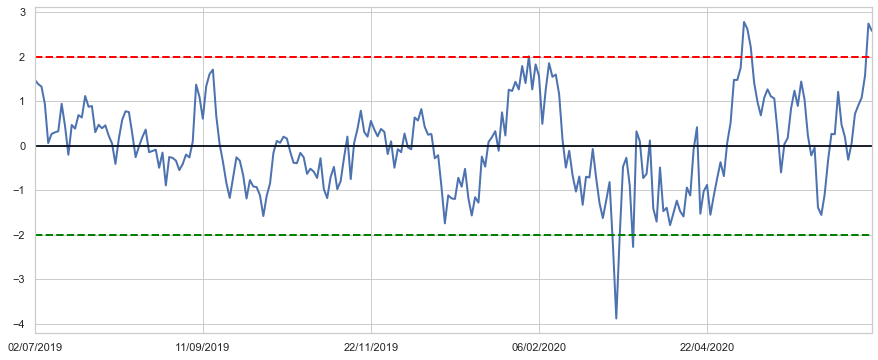

In [20]:
plot_residue(residue(y, x, period))

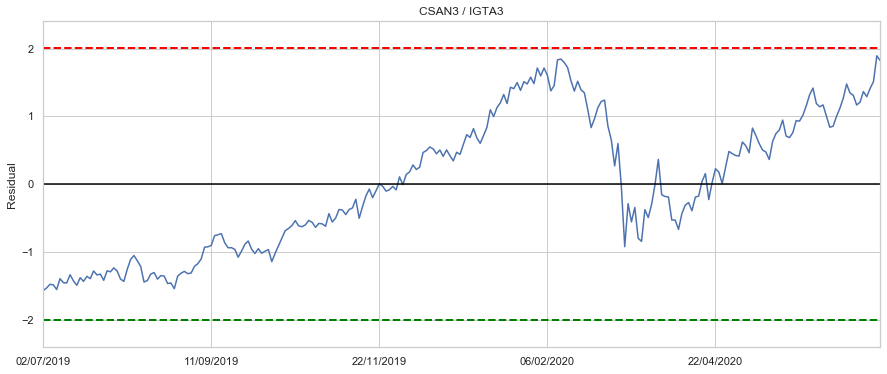

In [22]:
coint.show(data[::-1], y_symbol, x_symbol)

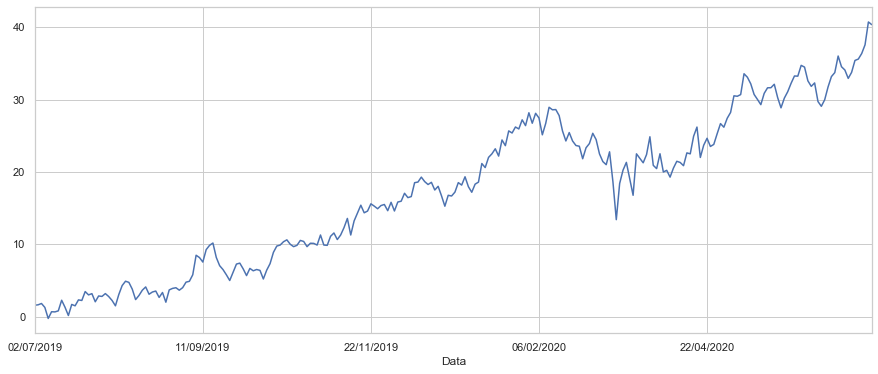

In [19]:
ratio_continuo(y, x, period)[::-1].plot(figsize=(15,6))